# Predicting Nitrogen, Phosphorous, Potassium, and Health State of Crops
## Thomas Butler


# Directions

- Make sure that "health.csv" and "predictors.csv" are saved in the same local folder as this Jupyter notebook file.
- The true health states and nutrient levels are found in "health.csv" and the predictors (spectral data) are found in "predictors.csv".

# Import Built-In Python Functions

#### Cell 1 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, ConfusionMatrixDisplay

#Packages not included in original code
%matplotlib inline
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tools.eval_measures import rmse
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay
from sklearn import tree
import graphviz 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Going through some EDA before modeling.

In [2]:
#just taking code from Cell 2
health = pd.read_csv('health.csv')
predictors = pd.read_csv('predictors.csv')

sample_level_df = pd.merge(predictors, health, on="sample_group_id")

# Take the mean of the predictors for the sample group
# Is averaging all sample group IDs a valid assumption? If so, why?
sample_group_level_df = sample_level_df.groupby(["sample_group_id","health_state"]).mean().reset_index()

In [3]:
sample_group_level_df.head()

,sample_group_id,health_state,sample_id,Clrededge710,Rededge1,REIP1,Ctr2,Datt1,Nitrogen,Phosphorous,Potassium
0,1,diseased,3.0,3.620195,3.4792,708.8214,0.09080,0.7280,1045.867392,242.452785,4834.782980
1,2,healthy,8.0,4.177324,4.0650,707.5898,0.15540,0.7314,1171.778916,390.562090,6748.608286
2,3,healthy,13.0,4.295281,3.6796,707.3080,0.16580,0.9084,1242.649810,230.062871,5980.437224
3,4,healthy,17.5,3.990763,4.2390,707.8735,0.16925,0.6505,1087.580670,267.668001,6769.226583
4,5,diseased,22.0,3.014626,4.0380,708.4182,0.08980,0.8074,1159.263663,272.437250,5230.018613


How were predictors calculated compared to nitrogen, phosphorous, and potassium? Since these are all numeric values, some noise/variance can be inside the calculations. Understanding these methods can help determine if these numbers are significantly different which can account for a less accurate model.

What are the predictors referencing? Understanding this can help determine if the data and any conclusions I make are logical, if there is a confounding factor, or if there is no logic and it is just noise. Here is an interesting example of why you can't only rely on data. https://www.tylervigen.com/spurious-correlations

In [4]:
#checking for null values.
sample_group_level_df.isnull().values.any()

False

In [5]:
#Column types
sample_group_level_df.dtypes

sample_group_id      int64
health_state        object
sample_id          float64
Clrededge710       float64
Rededge1           float64
REIP1              float64
Ctr2               float64
Datt1              float64
Nitrogen           float64
Phosphorous        float64
Potassium          float64
dtype: object

In [6]:
#Changing health_state to categorical data.
sample_group_level_df['health_state'] = sample_group_level_df['health_state'].astype('category')
sample_group_level_df.dtypes

sample_group_id       int64
health_state       category
sample_id           float64
Clrededge710        float64
Rededge1            float64
REIP1               float64
Ctr2                float64
Datt1               float64
Nitrogen            float64
Phosphorous         float64
Potassium           float64
dtype: object

In [7]:
#list of column names. Useful to have in list format.
sample_group_level_df.columns

Index(['sample_group_id', 'health_state', 'sample_id', 'Clrededge710',
       'Rededge1', 'REIP1', 'Ctr2', 'Datt1', 'Nitrogen', 'Phosphorous',
       'Potassium'],
      dtype='object')

In [8]:
#checking some summary statistics of columns in next 2 cells.
sample_group_level_df[['Clrededge710', 'Rededge1', 'REIP1', 'Ctr2', 'Datt1',
                       'Nitrogen', 'Phosphorous', 'Potassium', ]].describe()

,Clrededge710,Rededge1,REIP1,Ctr2,Datt1,Nitrogen,Phosphorous,Potassium
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.724165,3.827875,707.948867,0.169652,0.733539,1174.903631,273.668915,6083.322635
std,0.596341,0.496382,0.794054,0.055599,0.113379,120.867336,36.168149,756.542768
min,2.211713,2.114000,706.619200,0.071400,0.399400,832.411718,191.373348,4186.820932
25%,3.291834,3.595800,707.358100,0.115700,0.660250,1103.918860,247.579729,5507.338520
50%,3.830289,3.892700,707.748950,0.181300,0.742100,1170.975406,273.216986,6338.473772
75%,4.181490,4.164850,708.413250,0.210300,0.809000,1254.182442,298.686237,6620.072562
max,4.892604,5.199000,710.245000,0.303800,0.985500,1524.183615,390.562090,7257.599850


REIP1 is much larger than the other predictors which can cause issues depending on the models used. Might need to normalize the predictors depending on model.

In [9]:
sample_group_level_df[['sample_group_id', 'health_state']].groupby('health_state').count()

,sample_group_id
health_state,
diseased,28
healthy,72


In [10]:
# creating dummy variable from health_state.
sample_group_level_df['diseased'] = pd.get_dummies(sample_group_level_df["health_state"], dtype=int)['diseased']
sample_group_level_df.head()

,sample_group_id,health_state,sample_id,Clrededge710,Rededge1,REIP1,Ctr2,Datt1,Nitrogen,Phosphorous,Potassium,diseased
0,1,diseased,3.0,3.620195,3.4792,708.8214,0.09080,0.7280,1045.867392,242.452785,4834.782980,1
1,2,healthy,8.0,4.177324,4.0650,707.5898,0.15540,0.7314,1171.778916,390.562090,6748.608286,0
2,3,healthy,13.0,4.295281,3.6796,707.3080,0.16580,0.9084,1242.649810,230.062871,5980.437224,0
3,4,healthy,17.5,3.990763,4.2390,707.8735,0.16925,0.6505,1087.580670,267.668001,6769.226583,0
4,5,diseased,22.0,3.014626,4.0380,708.4182,0.08980,0.8074,1159.263663,272.437250,5230.018613,1


### Plots

<AxesSubplot:xlabel='Clrededge710', ylabel='Density'>

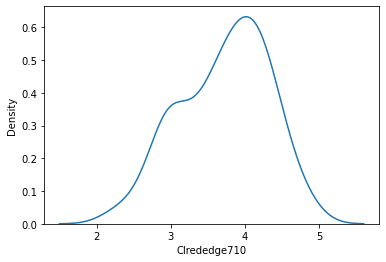

In [11]:
#kernel density estimate plot for distribution. rest of predictors below.
sns.kdeplot(data=sample_group_level_df, x="Clrededge710")

<AxesSubplot:xlabel='Datt1', ylabel='Density'>

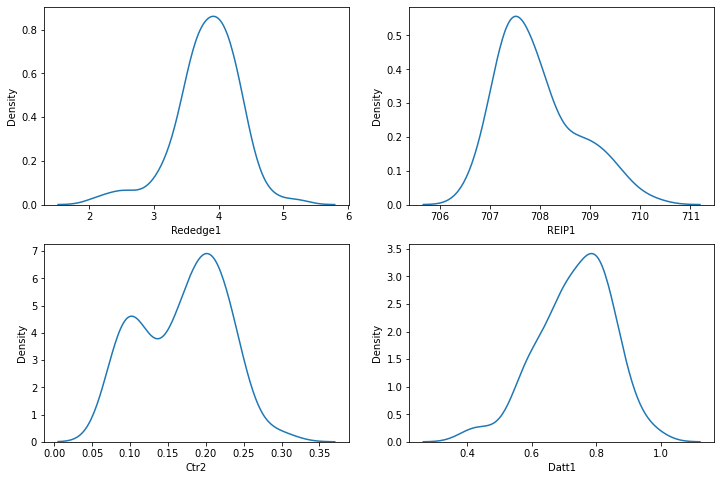

In [12]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#kernel density estimate plot to estimate distribution of each predictor
sns.kdeplot(data=sample_group_level_df, x="Rededge1", ax = axes[0,0])
sns.kdeplot(data=sample_group_level_df, x="REIP1", ax = axes[0,1])
sns.kdeplot(data=sample_group_level_df, x="Ctr2", ax = axes[1,0])
sns.kdeplot(data=sample_group_level_df, x="Datt1", ax = axes[1,1])

Looks like data mostly fits a normal distribution

In [13]:
#Shapiro Wilk test is a statistic test to determine if predictors are normal distribution
for col in ['Clrededge710', 'Rededge1', 'REIP1', 'Ctr2', 'Datt1']:
    print(col + " p_value = " + str(shapiro(sample_group_level_df[col])[1]))

Clrededge710 p_value = 0.05583217740058899
Rededge1 p_value = 0.0011654688278213143
REIP1 p_value = 0.00014781886420678347
Ctr2 p_value = 0.0015923635801300406
Datt1 p_value = 0.1066790372133255


Well, we have Clrededge710 and Datt1 fail the null hypothesis with a p > 0.05 meaning Clrededge710 and Datt1 are not siggnificantly different from a normal distribution. 

Might need to try to standardize or normalize the data.

<AxesSubplot:xlabel='Ctr2', ylabel='health_state'>

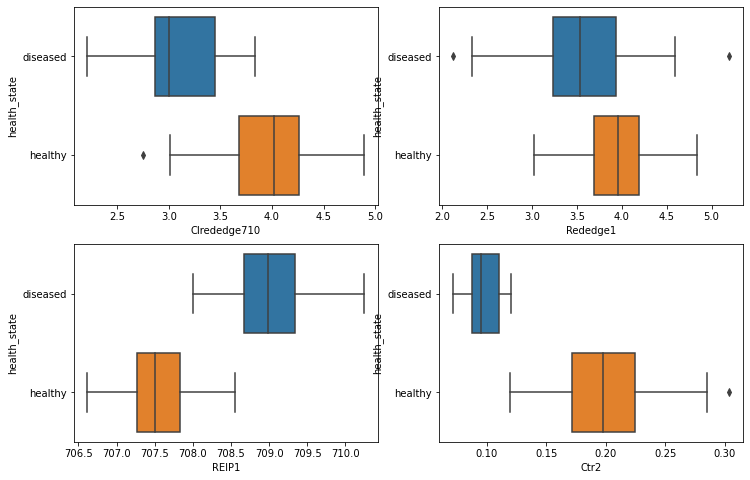

In [14]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting box plots of each predictor
sns.boxplot(data=sample_group_level_df, x="Clrededge710", y="health_state", ax=axes[0,0])
sns.boxplot(data=sample_group_level_df, x="Rededge1", y="health_state", ax=axes[0,1])
sns.boxplot(data=sample_group_level_df, x="REIP1", y="health_state", ax=axes[1,0])
sns.boxplot(data=sample_group_level_df, x="Ctr2", y="health_state", ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='health_state'>

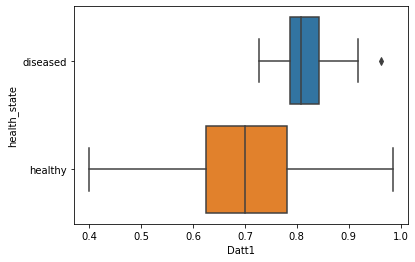

In [15]:
# separating out 5th predictor because it doesn't fit neatly
sns.boxplot(data=sample_group_level_df, x="Datt1", y="health_state")

The data has very different distributions when comparing health_state vs predictors. This might have caused the Shapiro Wilk test to fail and these look like normal distributions. Rededge1 might be the worse predictor since the data distribution of both categories match closely.

There are few outliers that are not fair away from distribution distance wise. If I saw a outlier very far off from the distribution I would figure out which data point that was and figure out how and why it is different than rest of data. Here we could also examine these points but I suspect they will have little affect on modeling.

<AxesSubplot:xlabel='Ctr2', ylabel='Nitrogen'>

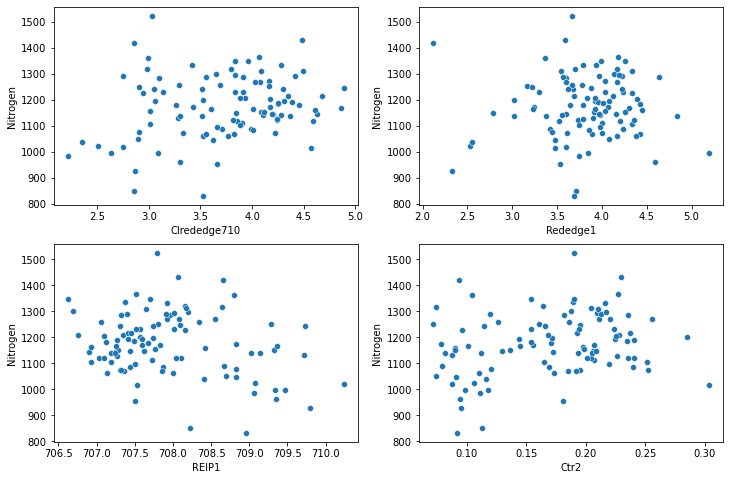

In [16]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting scatter plots of each predictor with Nitrogen
sns.scatterplot(data=sample_group_level_df, x="Clrededge710", y="Nitrogen", ax=axes[0,0])
sns.scatterplot(data=sample_group_level_df, x="Rededge1", y="Nitrogen", ax=axes[0,1])
sns.scatterplot(data=sample_group_level_df, x="REIP1", y="Nitrogen", ax=axes[1,0])
sns.scatterplot(data=sample_group_level_df, x="Ctr2", y="Nitrogen", ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='Nitrogen'>

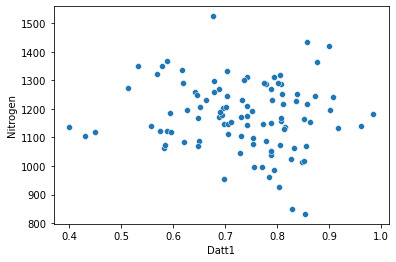

In [17]:
# separating out 5th predictor because it doesn't fit neatly
sns.scatterplot(data=sample_group_level_df, x="Datt1", y="Nitrogen")

Well there doesn't seem to be any strong correlation between Nitrogen and any other predictor. Doesn't seem like there is any non-linear relationship or transformation that will help.

<AxesSubplot:xlabel='Ctr2', ylabel='Phosphorous'>

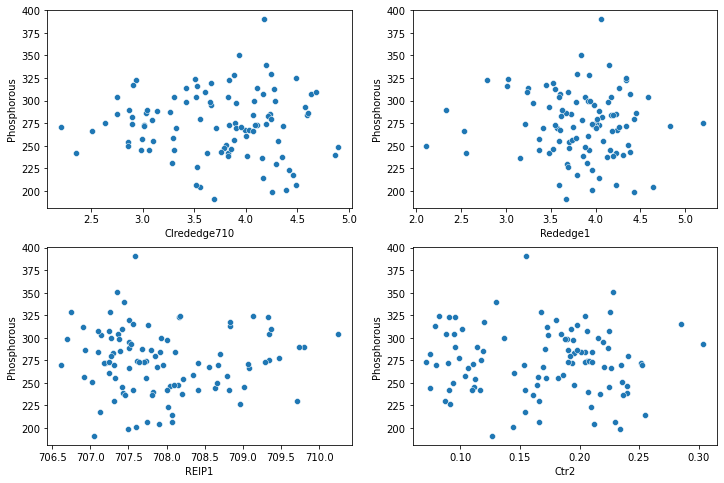

In [18]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting scatter plots of each predictor with Phosphorous
sns.scatterplot(data=sample_group_level_df, x="Clrededge710", y="Phosphorous", ax=axes[0,0])
sns.scatterplot(data=sample_group_level_df, x="Rededge1", y="Phosphorous", ax=axes[0,1])
sns.scatterplot(data=sample_group_level_df, x="REIP1", y="Phosphorous", ax=axes[1,0])
sns.scatterplot(data=sample_group_level_df, x="Ctr2", y="Phosphorous", ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='Phosphorous'>

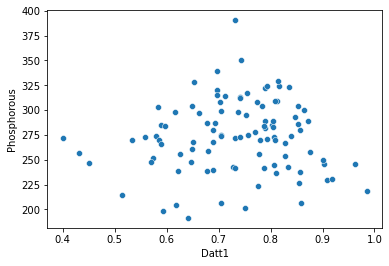

In [19]:
# separating out 5th predictor because it doesn't fit neatly
sns.scatterplot(data=sample_group_level_df, x="Datt1", y="Phosphorous")

Well there doesn't seem to be any correlation between Phosphorous and any other predictor. Doesn't seem like there is any non-linear relationship or transformation that will help.

<AxesSubplot:xlabel='Ctr2', ylabel='Potassium'>

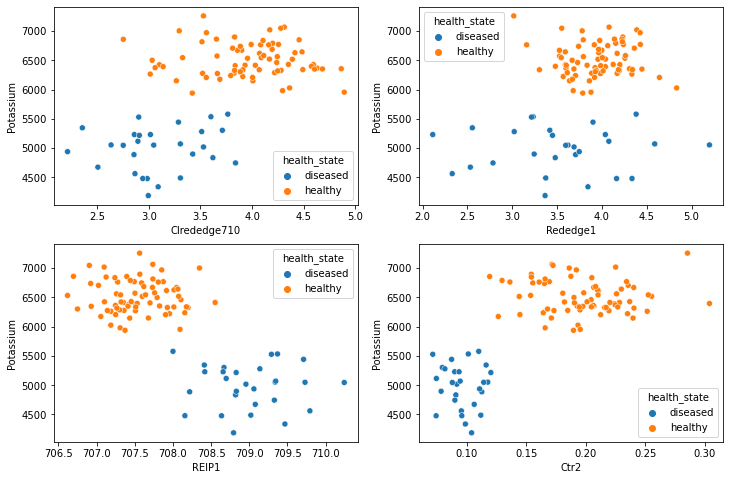

In [20]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting scatter plots of each predictor with Potassium
sns.scatterplot(data=sample_group_level_df, x="Clrededge710", y="Potassium", hue='health_state', ax=axes[0,0])
sns.scatterplot(data=sample_group_level_df, x="Rededge1", y="Potassium", hue='health_state', ax=axes[0,1])
sns.scatterplot(data=sample_group_level_df, x="REIP1", y="Potassium", hue='health_state', ax=axes[1,0])
sns.scatterplot(data=sample_group_level_df, x="Ctr2", y="Potassium", hue='health_state', ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='Potassium'>

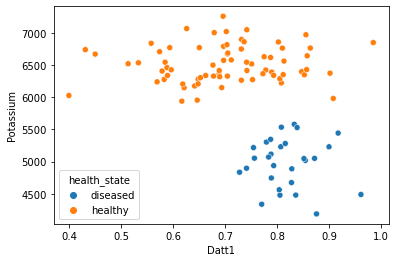

In [21]:
# separating out 5th predictor because it doesn't fit neatly
sns.scatterplot(data=sample_group_level_df, x="Datt1", y="Potassium", hue='health_state')

I added health_state into the graph since the data looked grouped and that explains the variation.

It is interesting how fertilizer supplies plants with plenty of Nitrogen, Phosphorous, and Potassium but Potassium is the nutrient which decreases during disease.

In [22]:
#Split dataframe by health_state to determine if data is normally distributed.
sample_group_level_df_diseased = sample_group_level_df[(sample_group_level_df.health_state == "diseased")]

#Shapiro Wilk test is a statistic test to determine if predictors are normal distribution
for col in ['Clrededge710', 'Rededge1', 'REIP1', 'Ctr2', 'Datt1']:
    print(col + " p_value = " + str(shapiro(sample_group_level_df_diseased[col])[1]))

Clrededge710 p_value = 0.501145601272583
Rededge1 p_value = 0.9554309844970703
REIP1 p_value = 0.9610424041748047
Ctr2 p_value = 0.3265434503555298
Datt1 p_value = 0.42320695519447327


In [23]:
sample_group_level_df_healthy = sample_group_level_df[(sample_group_level_df.health_state == "healthy")]

#Shapiro Wilk test is a statistic test to determine if predictors are normal distribution
for col in ['Clrededge710', 'Rededge1', 'REIP1', 'Ctr2', 'Datt1']:
    print(col + " p_value = " + str(shapiro(sample_group_level_df_healthy[col])[1]))

Clrededge710 p_value = 0.1894054263830185
Rededge1 p_value = 0.8489801287651062
REIP1 p_value = 0.9573791027069092
Ctr2 p_value = 0.7897188663482666
Datt1 p_value = 0.8456726670265198


All predictors fail Shapiro Wilk test when separated by health_state class. This means that these predictors are not significantly different from a normal distribution.

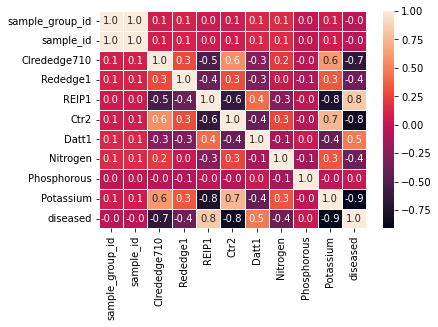

In [24]:
#correlation matrix with heatmap
corr_matrix = sample_group_level_df.corr()
sns.heatmap(corr_matrix, annot=True, linewidth=.5, fmt=".1f")
plt.show()

There is some correlation between Nitrogen and the predictors.

It doesn't look like Phosphorous has any correlation between the predictors. Not sure how to model this. With data looking how Phosphorous looks, I would try to gather different data to analyze other relationships.

Potassium has very strong correlation between alot of the predictors.

<AxesSubplot:xlabel='Rededge1', ylabel='Datt1'>

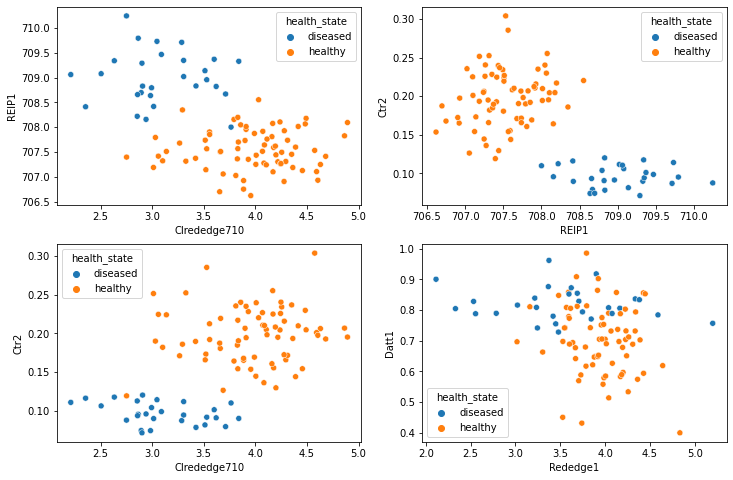

In [25]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting most interesting correlations of predictors with health_state. Included Rededge1 vs Datt1 because was missing from other comparisons.
sns.scatterplot(data = sample_group_level_df, x='Clrededge710', y='REIP1', hue='health_state', ax=axes[0,0])
sns.scatterplot(data = sample_group_level_df, x='Clrededge710', y='Ctr2', hue='health_state', ax=axes[1,0])
sns.scatterplot(data = sample_group_level_df, x='REIP1', y='Ctr2', hue='health_state', ax=axes[0,1])
sns.scatterplot(data = sample_group_level_df, x='Rededge1', y='Datt1', hue='health_state', ax=axes[1,1])

Can see some clear separation between groups.

## Modeling

### Nitrogen

#### Linear Regression

Lets run data on 3 separate sets, one unmodifed, one standardized and one normalized.

In [26]:
#Standardize data for Linear regression, keep separate to run on both unmodified and standardized data.
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Nitrogen']]

#Split data 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# copy predictors
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

#all predictors are numeric so don't need to pick only numeric columns.
for col in X_train_stand.columns:
    
    # find scale
    scale = StandardScaler().fit(X_train_stand[[col]])
    
    # transform Train and test data
    X_train_stand[col] = scale.transform(X_train_stand[[col]])
    X_test_stand[col] = scale.transform(X_test_stand[[col]])
X_train_stand.head()

,Clrededge710,Rededge1,REIP1,Ctr2,Datt1
0,-0.752092,0.190615,2.059636,-1.400493,1.649780
1,1.069676,0.298542,-0.423162,-0.387434,0.061478
2,-0.721459,1.536576,1.630960,-1.272077,0.374181
3,0.138682,0.161287,-0.702683,0.340255,-0.920485
4,-1.387866,-1.148699,1.564956,-1.682294,0.896624


In [27]:
#Normalize data.
#first copy data.
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

for col in X_train_norm.columns:
    
    # find scale
    norm = MinMaxScaler().fit(X_train_norm[[col]])
    
    # transform Train and test data
    X_train_norm[col] = norm.transform(X_train_norm[[col]])
    X_test_stand[col] = norm.transform(X_test_stand[[col]])

print(X_train_norm.head())

#good it worked.
X_train_norm.describe()

   Clrededge710  Rededge1     REIP1      Ctr2     Datt1
0      0.400882  0.656933  0.853053  0.067986  0.884491
1      0.812376  0.677234  0.270009  0.312392  0.600239
2      0.407801  0.910114  0.752386  0.098967  0.656202
3      0.602086  0.651416  0.204369  0.487952  0.424501
4      0.257275  0.405002  0.736886  0.000000  0.749701


,Clrededge710,Rededge1,REIP1,Ctr2,Datt1
count,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.570762,0.621077,0.369382,0.405863,0.589236
std,0.227507,0.189463,0.236529,0.242998,0.180258
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.402612,0.543711,0.202631,0.166900,0.455383
50%,0.602911,0.634535,0.300265,0.436317,0.616789
75%,0.755654,0.764224,0.532010,0.581971,0.709734
max,1.000000,1.000000,1.000000,1.000000,1.000000


                            OLS Regression Results                            
Dep. Variable:               Nitrogen   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.676
Date:                Sun, 16 Jul 2023   Prob (F-statistic):              0.153
Time:                        21:56:08   Log-Likelihood:                -436.17
No. Observations:                  70   AIC:                             884.3
Df Residuals:                      64   BIC:                             897.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.819e+04   1.93e+04      1.464   

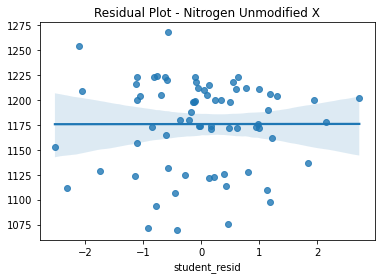

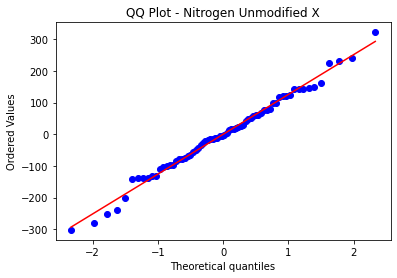

RMSE of Linear Regression of Nitrogen using unmodified X: 96.18403816562069


In [28]:
#Nitrogen Linear Regression - Unmodified X
X_train = sm.add_constant(X_train)
LR_Nitrogen = sm.OLS(y_train,X_train).fit()
print(LR_Nitrogen.summary())

#residual plot
r_student = LR_Nitrogen.outlier_test()["student_resid"]
sns.regplot(x=r_student,y=LR_Nitrogen.fittedvalues)
plt.title("Residual Plot - Nitrogen Unmodified X")
plt.show()
plt.close('all')

#qq plot
fig, ax = plt.subplots()
_, (__, ___, r) = stats.probplot(LR_Nitrogen.resid, plot=ax, fit=True)
plt.title("QQ Plot - Nitrogen Unmodified X")
plt.show()
plt.close('all')

# now generate predictions
X_test = sm.add_constant(X_test)
ypred = LR_Nitrogen.predict(X_test)

# calc rmse
rmse_LR_Nitrogen = rmse(y_test['Nitrogen'], ypred)
print("RMSE of Linear Regression of Nitrogen using unmodified X: " + str(rmse_LR_Nitrogen))

Looking at these statisics I could optimize with Elastic net but I am letting XGBoost do that.

                            OLS Regression Results                            
Dep. Variable:               Nitrogen   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.676
Date:                Sun, 16 Jul 2023   Prob (F-statistic):              0.153
Time:                        21:56:09   Log-Likelihood:                -436.17
No. Observations:                  70   AIC:                             884.3
Df Residuals:                      64   BIC:                             897.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1175.8186     15.373     76.484   

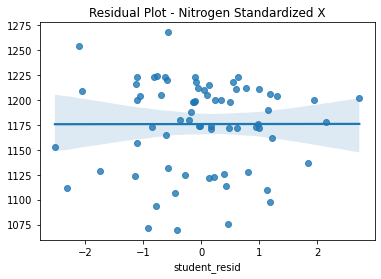

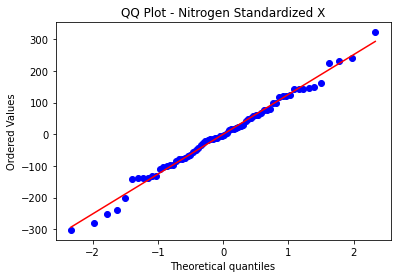

RMSE of Linear Regression of Nitrogen using Standardized X: 6349.9607741785285


In [29]:
#Nitrogen Linear Regression - Standardized X
X_train_stand = sm.add_constant(X_train_stand)
LR_Nitrogen_stand = sm.OLS(y_train,X_train_stand).fit()
print(LR_Nitrogen_stand.summary())

#residual plot
r_student = LR_Nitrogen_stand.outlier_test()["student_resid"]
sns.regplot(x=r_student,y=LR_Nitrogen_stand.fittedvalues)
plt.title("Residual Plot - Nitrogen Standardized X")
plt.show()
plt.close('all')

#qq plot
fig, ax = plt.subplots()
_, (__, ___, r) = stats.probplot(LR_Nitrogen_stand.resid, plot=ax, fit=True)
plt.title("QQ Plot - Nitrogen Standardized X")
plt.show()
plt.close('all')

# now generate predictions
X_test_stand = sm.add_constant(X_test_stand)
ypred = LR_Nitrogen_stand.predict(X_test_stand)

# calc rmse
rmse_LR_Nitrogen_stand = rmse(y_test['Nitrogen'], ypred)
print("RMSE of Linear Regression of Nitrogen using Standardized X: " + str(rmse_LR_Nitrogen_stand))

                            OLS Regression Results                            
Dep. Variable:               Nitrogen   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.676
Date:                Sun, 16 Jul 2023   Prob (F-statistic):              0.153
Time:                        21:56:10   Log-Likelihood:                -436.17
No. Observations:                  70   AIC:                             884.3
Df Residuals:                      64   BIC:                             897.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1251.6214    120.412     10.394   

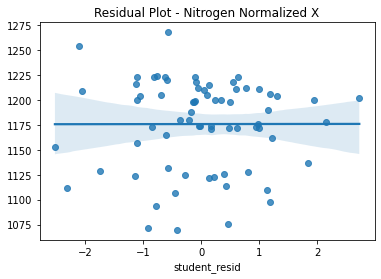

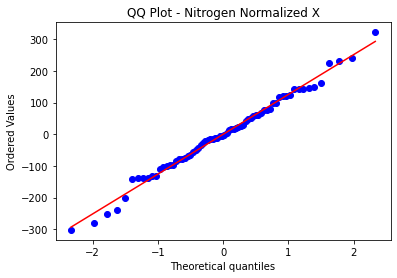

RMSE of Linear Regression of Nitrogen using Normalized X: 97966.57762229786


In [30]:
#Nitrogen Linear Regression - Normalized X
X_train_norm = sm.add_constant(X_train_norm)
LR_Nitrogen_norm = sm.OLS(y_train,X_train_norm).fit()
print(LR_Nitrogen_norm.summary())

#residual plot
r_student = LR_Nitrogen_norm.outlier_test()["student_resid"]
sns.regplot(x=r_student,y=LR_Nitrogen_norm.fittedvalues)
plt.title("Residual Plot - Nitrogen Normalized X")
plt.show()
plt.close('all')

#qq plot
fig, ax = plt.subplots()
_, (__, ___, r) = stats.probplot(LR_Nitrogen_norm.resid, plot=ax, fit=True)
plt.title("QQ Plot - Nitrogen Normalized X")
plt.show()
plt.close('all')

# now generate predictions
X_test_norm = sm.add_constant(X_test_norm)
ypred = LR_Nitrogen_norm.predict(X_test_norm)

# calc rmse
rmse_LR_Nitrogen_norm = rmse(y_test['Nitrogen'], ypred)
print("RMSE of Linear Regression of Nitrogen using Normalized X: " + str(rmse_LR_Nitrogen_norm))

Seems like unmodified data performed the best with Linear Regression.

#### XGBoost

In [31]:
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Nitrogen']]

#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [32]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [33]:
# set training to linear regression
params = {"objective": "reg:squarederror"}

evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

n = 5000

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   early_stopping_rounds=5
)

[0]	validation-rmse:839.95453	train-rmse:837.95880
[50]	validation-rmse:99.33826	train-rmse:0.09852
[89]	validation-rmse:99.33094	train-rmse:0.00084


In [34]:
ypred = model.predict(dtest_reg)
rmse_XGB = rmse(y_test['Nitrogen'], ypred)
print("RMSE of XGB of Nitrogen: " + str(rmse_XGB))

RMSE of XGB of Nitrogen: 101.01630236156576


Seems like the model is overfit.

In [35]:
#Split data 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [36]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [37]:
# set training to linear regression
params = {"objective": "reg:squarederror"}

n = 5000
results = xgb.cv(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    verbose_eval=50,
    early_stopping_rounds=5,
    nfold=5
)

[0]	train-rmse:835.88000+6.53522	test-rmse:835.14589+38.80257
[18]	train-rmse:12.15114+1.86465	test-rmse:147.54057+27.23632


In [38]:
best_rmse = results['test-rmse-mean'].min()
best_rmse

146.354306

Yep, overfit. Will try hyperparameter training.

#### XGBoost - Hyperparameter training -- Best Model

In [39]:
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Nitrogen']]

#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [40]:
# set training to linear regression
# Testing other hyperparameters through intuition
# quick guide on hyperparameter tuning https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
# documentation: https://xgboost.readthedocs.io/en/latest/parameter.html
# I didn't run on GPU acceleration because code ran fast and potential complexities surrounding gpu installation, if code is running slow, look up implementation for xgboost gpu acceleration.
# with a larger amount of data points either increase the learning rate or let training take more time.
params = {"objective": "reg:squarederror",
          'max_depth': 7,
          'learning_rate':0.01,
          'colsample_bytree': 0.5,
          'subsample':0.6,
          'alpha':0,
          'lambda':1,
          'gamma':3}

evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

n = 480

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   early_stopping_rounds=5
)

[0]	validation-rmse:1174.75476	train-rmse:1171.22205
[10]	validation-rmse:1066.44885	train-rmse:1063.30713
[20]	validation-rmse:968.97076	train-rmse:966.25598
[30]	validation-rmse:880.40283	train-rmse:878.15894
[40]	validation-rmse:798.81659	train-rmse:797.09937
[50]	validation-rmse:726.42151	train-rmse:725.27148
[60]	validation-rmse:659.88147	train-rmse:659.36340
[70]	validation-rmse:600.22937	train-rmse:600.39764
[80]	validation-rmse:546.11908	train-rmse:547.38196
[90]	validation-rmse:496.81992	train-rmse:499.31259
[100]	validation-rmse:451.96158	train-rmse:455.68588
[110]	validation-rmse:410.46478	train-rmse:415.81445
[120]	validation-rmse:374.28604	train-rmse:381.30930
[130]	validation-rmse:342.22342	train-rmse:350.64545
[140]	validation-rmse:311.98361	train-rmse:321.94632
[150]	validation-rmse:285.05539	train-rmse:296.20169
[160]	validation-rmse:259.97672	train-rmse:273.10483
[170]	validation-rmse:239.03497	train-rmse:252.75969
[180]	validation-rmse:221.05104	train-rmse:235.10069


In [41]:
ypred = model.predict(dval_reg)
rmse_XGB = rmse(y_val['Nitrogen'], ypred)
print("RMSE of XGB of Nitrogen: " + str(rmse_XGB))

RMSE of XGB of Nitrogen: 84.92733332476921


In [42]:
ypred = model.predict(dtest_reg)
rmse_XGB = rmse(y_test['Nitrogen'], ypred)
print("RMSE of XGB of Nitrogen: " + str(rmse_XGB))

RMSE of XGB of Nitrogen: 69.05387383947073


That is better than linear regression. Is a bit hard to further optimize without potentially overfitting training data.

Will try Elastic Net Regression on Nitrogen.

#### Elastic Net Regression

In [43]:
#Standardize data for Linear regression, keep separate to run on both unmodified and standardized data.
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Nitrogen']]

#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

#Nitrogen Ridge Regression
LR_EN_Nitrogen = ElasticNet(random_state=42, l1_ratio=0)
LR_EN_Nitrogen.fit(X_train, y_train)
print("Clrededge710 Coefficient: " + str(LR_EN_Nitrogen.coef_[0]))
print("Rededge1 Coefficient: " + str(LR_EN_Nitrogen.coef_[1]))
print("REIP1 Coefficient: " + str(LR_EN_Nitrogen.coef_[2]))
print("Ctr2 Coefficient: " + str(LR_EN_Nitrogen.coef_[3]))
print("Datt1 Coefficient: " + str(LR_EN_Nitrogen.coef_[4]))
print("Intercept: " + str(LR_EN_Nitrogen.intercept_[0]))

ypred = LR_EN_Nitrogen.predict(X_val)
rmse_LR_Nitrogen = rmse(y_val['Nitrogen'], ypred)
print("RMSE of Ridge Regression of Nitrogen: " + str(rmse_LR_Nitrogen))

Clrededge710 Coefficient: 6.25178051407394
Rededge1 Coefficient: -1.5594962749810983
REIP1 Coefficient: -18.256215755469057
Ctr2 Coefficient: 1.400218313660349
Datt1 Coefficient: -0.867733609014302
Intercept: 14083.413052143023
RMSE of Ridge Regression of Nitrogen: 92.74929356112641


C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.745e+05, tolerance: 1.197e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [44]:
ypred = LR_EN_Nitrogen.predict(X_test)
rmse_LR_Nitrogen = rmse(y_test['Nitrogen'], ypred)
print("RMSE of Ridge Regression of Nitrogen: " + str(rmse_LR_Nitrogen))

RMSE of Ridge Regression of Nitrogen: 84.31889009186547


XGBoost has best RMSE on Nitrogen at 69.05.

### Phosphorous

#### Linear Regression

                            OLS Regression Results                            
Dep. Variable:            Phosphorous   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.3527
Date:                Sun, 16 Jul 2023   Prob (F-statistic):              0.879
Time:                        21:56:13   Log-Likelihood:                -353.45
No. Observations:                  70   AIC:                             718.9
Df Residuals:                      64   BIC:                             732.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          876.3853   5907.120      0.148   

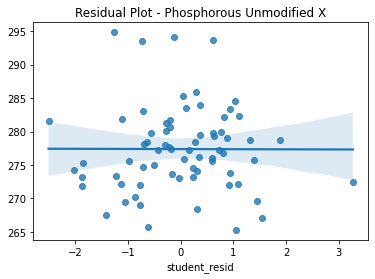

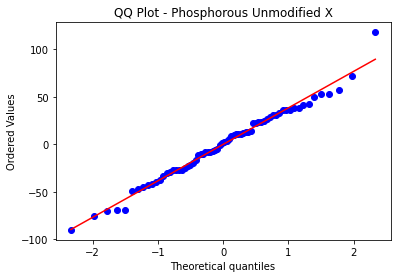

RMSE of Linear Regression of Phosphorous using unmodified X: 33.472084414089146


In [45]:
#Standardize data for Linear regression, keep separate to run on both unmodified and standardized data.
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Phosphorous']]

#Split data 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Phosphorous Linear Regression - Unmodified X
X_train = sm.add_constant(X_train)
LR_Phosphorous = sm.OLS(y_train,X_train).fit()
print(LR_Phosphorous.summary())

#residual plot
r_student = LR_Phosphorous.outlier_test()["student_resid"]
sns.regplot(x=r_student,y=LR_Phosphorous.fittedvalues)
plt.title("Residual Plot - Phosphorous Unmodified X")
plt.show()
plt.close('all')

#qq plot
fig, ax = plt.subplots()
_, (__, ___, r) = stats.probplot(LR_Phosphorous.resid, plot=ax, fit=True)
plt.title("QQ Plot - Phosphorous Unmodified X")
plt.show()
plt.close('all')

# now generate predictions
X_test = sm.add_constant(X_test)
ypred = LR_Phosphorous.predict(X_test)

# calc rmse
rmse_LR_Phosphorous = rmse(y_test['Phosphorous'], ypred)
print("RMSE of Linear Regression of Phosphorous using unmodified X: " + str(rmse_LR_Phosphorous))

#### XGBoost

In [46]:
#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [47]:
# set training to linear regression
# Testing other hyperparameters through intuition
# quick guide on hyperparameter tuning https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
# documentation: https://xgboost.readthedocs.io/en/latest/parameter.html
# I didn't run on GPU acceleration because code ran fast and potential complexities surrounding gpu installation, if code is running slow, look up implementation for xgboost gpu acceleration.
# with a larger amount of data points either increase the learning rate or let training take more time.
params = {"objective": "reg:squarederror",
          'max_depth': 8,
          'learning_rate':0.01,
          'colsample_bytree': 0.6,
          'subsample':0.5,
          'alpha':0,
          'lambda':1,
          'gamma':1}

evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

n = 405

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=5,
   early_stopping_rounds=5
)

[0]	validation-rmse:266.65830	train-rmse:276.82486
[5]	validation-rmse:253.67419	train-rmse:263.88867
[10]	validation-rmse:241.61499	train-rmse:251.87808
[15]	validation-rmse:229.81410	train-rmse:240.12915
[20]	validation-rmse:218.68578	train-rmse:229.05434
[25]	validation-rmse:208.05681	train-rmse:218.48117
[30]	validation-rmse:197.90588	train-rmse:208.38838
[35]	validation-rmse:188.19200	train-rmse:198.73515
[40]	validation-rmse:179.18041	train-rmse:189.78482
[45]	validation-rmse:170.35719	train-rmse:181.02687
[50]	validation-rmse:162.13895	train-rmse:172.87468
[55]	validation-rmse:154.25461	train-rmse:165.10605
[60]	validation-rmse:146.70407	train-rmse:157.62569
[65]	validation-rmse:139.79324	train-rmse:150.66548
[70]	validation-rmse:133.26411	train-rmse:143.98868
[75]	validation-rmse:127.05275	train-rmse:137.67815
[80]	validation-rmse:120.91687	train-rmse:131.55179
[85]	validation-rmse:115.25968	train-rmse:125.80880
[90]	validation-rmse:109.94314	train-rmse:120.48830
[95]	validatio

In [48]:
ypred = model.predict(dtest_reg)
rmse_XGB = rmse(y_test['Phosphorous'], ypred)
print("RMSE of XGB of Phosphorous: " + str(rmse_XGB))

RMSE of XGB of Phosphorous: 35.616981775199605


Linear regression seems to be best for Phosphorous. I will use Elastic Net Linear Regression for Phosphorous.

#### Elastic Net Linear Regression -- Best Model

In [49]:
#Elastic Net Linear Regression
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Phosphorous']]

#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

#Phosphorous Ridge Regression
LR_EN_Phosphorous = ElasticNet(random_state=42, l1_ratio=0)
LR_EN_Phosphorous.fit(X_train, y_train)
print("Clrededge710 Coefficient: " + str(LR_EN_Phosphorous.coef_[0]))
print("Rededge1 Coefficient: " + str(LR_EN_Phosphorous.coef_[1]))
print("REIP1 Coefficient: " + str(LR_EN_Phosphorous.coef_[2]))
print("Ctr2 Coefficient: " + str(LR_EN_Phosphorous.coef_[3]))
print("Datt1 Coefficient: " + str(LR_EN_Phosphorous.coef_[4]))
print("Intercept: " + str(LR_EN_Phosphorous.intercept_[0]))

ypred = LR_EN_Phosphorous.predict(X_val)
rmse_LR_Phosphorous = rmse(y_val['Phosphorous'], ypred)
print("RMSE of Linear Regression of Phosphorous using unmodified X: " + str(rmse_LR_Phosphorous))

Clrededge710 Coefficient: -0.9837996382744991
Rededge1 Coefficient: -1.9493114795286508
REIP1 Coefficient: 0.10842591238703041
Ctr2 Coefficient: 0.024949852120725063
Datt1 Coefficient: -0.1180360478853172
Intercept: 211.79959835656882
RMSE of Linear Regression of Phosphorous using unmodified X: 31.17901098611028


C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.096e+04, tolerance: 1.024e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [50]:
ypred = LR_EN_Phosphorous.predict(X_test)
rmse_LR_Phosphorous = rmse(y_test['Phosphorous'], ypred)
print("RMSE of Linear Regression of Phosphorous using unmodified X: " + str(rmse_LR_Phosphorous))

RMSE of Linear Regression of Phosphorous using unmodified X: 30.761327386513834


Phosphorous has best RMSE on Ridge Regression at 30.76.

### Potassium

#### Linear Regression

                            OLS Regression Results                            
Dep. Variable:              Potassium   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     32.46
Date:                Sun, 16 Jul 2023   Prob (F-statistic):           2.50e-16
Time:                        21:56:15   Log-Likelihood:                -519.29
No. Observations:                  70   AIC:                             1051.
Df Residuals:                      64   BIC:                             1064.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.074e+05   6.31e+04      4.870   

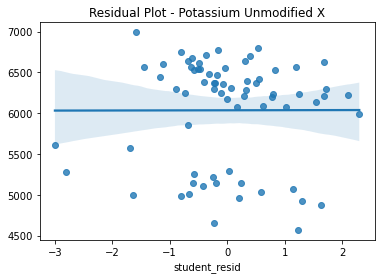

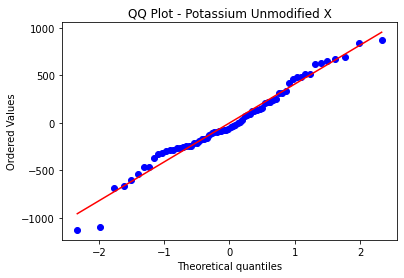

RMSE of Linear Regression of Potassium using unmodified X: 456.03722529032814


In [51]:
#Potassium Linear Regression
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Potassium']]

#Split data 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Potassium Linear Regression - Unmodified X
X_train = sm.add_constant(X_train)
LR_Potassium = sm.OLS(y_train,X_train).fit()
print(LR_Potassium.summary())

#residual plot
r_student = LR_Potassium.outlier_test()["student_resid"]
sns.regplot(x=r_student,y=LR_Potassium.fittedvalues)
plt.title("Residual Plot - Potassium Unmodified X")
plt.show()
plt.close('all')

#qq plot
fig, ax = plt.subplots()
_, (__, ___, r) = stats.probplot(LR_Potassium.resid, plot=ax, fit=True)
plt.title("QQ Plot - Potassium Unmodified X")
plt.show()
plt.close('all')

# now generate predictions
X_test = sm.add_constant(X_test)
ypred = LR_Potassium.predict(X_test)

# calc rmse
rmse_LR_Potassium = rmse(y_test['Potassium'], ypred)
print("RMSE of Linear Regression of Potassium using unmodified X: " + str(rmse_LR_Potassium))

#### XGBoost

In [52]:
#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [53]:
# set training to linear regression
# Testing other hyperparameters through intuition
# quick guide on hyperparameter tuning https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
# documentation: https://xgboost.readthedocs.io/en/latest/parameter.html
# I didn't run on GPU acceleration because code ran fast and potential complexities surrounding gpu installation, if code is running slow, look up implementation for xgboost gpu acceleration.
# with a larger amount of data points either increase the learning rate or let training take more time.
params = {"objective": "reg:squarederror",
          'max_depth': 8,
          'learning_rate': 0.01,
          'colsample_bytree': 0.5,
          'subsample': 0.6,
          'alpha': 0.5,
          'lambda': 1,
          'gamma': 1}

evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

n = 630

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   early_stopping_rounds=5
)

[0]	validation-rmse:6157.44531	train-rmse:6023.91943
[10]	validation-rmse:5601.19043	train-rmse:5470.94824
[20]	validation-rmse:5097.22949	train-rmse:4969.95459
[30]	validation-rmse:4640.46533	train-rmse:4518.59570
[40]	validation-rmse:4222.29883	train-rmse:4106.06543
[50]	validation-rmse:3844.89258	train-rmse:3735.45483
[60]	validation-rmse:3495.99780	train-rmse:3394.64917
[70]	validation-rmse:3182.40747	train-rmse:3086.87134
[80]	validation-rmse:2897.78076	train-rmse:2810.64404
[90]	validation-rmse:2640.88989	train-rmse:2556.63916
[100]	validation-rmse:2405.47095	train-rmse:2327.91724
[110]	validation-rmse:2188.64185	train-rmse:2118.86914
[120]	validation-rmse:1995.88879	train-rmse:1932.96252
[130]	validation-rmse:1819.56201	train-rmse:1760.27820
[140]	validation-rmse:1656.13977	train-rmse:1603.98999
[150]	validation-rmse:1512.20288	train-rmse:1462.86890
[160]	validation-rmse:1384.85229	train-rmse:1336.95752
[170]	validation-rmse:1265.98914	train-rmse:1220.37341
[180]	validation-rmse

In [54]:
ypred = model.predict(dtest_reg)
rmse_XGB = rmse(y_test['Potassium'], ypred)
print("RMSE of XGB of Potassium: " + str(rmse_XGB))

RMSE of XGB of Potassium: 468.8044765575758


Linear regression seems to be best for Potassium. I will use Elastic Net Linear Regression for Potassium.

#### Elastic Net Linear Regression

In [55]:
#Standardize data for Linear regression, keep separate to run on both unmodified and standardized data.
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['Potassium']]

#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

#Potassium Lasso Regression
LR_EN_Potassium = ElasticNet(random_state=42, l1_ratio=1)
LR_EN_Potassium.fit(X_train, y_train)
print("Clrededge710 Coefficient: " + str(LR_EN_Potassium.coef_[0]))
print("Rededge1 Coefficient: " + str(LR_EN_Potassium.coef_[1]))
print("REIP1 Coefficient: " + str(LR_EN_Potassium.coef_[2]))
print("Ctr2 Coefficient: " + str(LR_EN_Potassium.coef_[3]))
print("Datt1 Coefficient: " + str(LR_EN_Potassium.coef_[4]))
print("Intercept: " + str(LR_EN_Potassium.intercept_[0]))

ypred = LR_EN_Potassium.predict(X_val)
rmse_LR_Potassium = rmse(y_val['Potassium'], ypred)
print("RMSE of Lasso Regression of Potassium: " + str(rmse_LR_Potassium))

Clrededge710 Coefficient: 159.7112300966043
Rededge1 Coefficient: 100.97028208244275
REIP1 Coefficient: -442.47552565816653
Ctr2 Coefficient: 4055.406441890018
Datt1 Coefficient: 224.3478413223647
Intercept: 317469.8801354555
RMSE of Lasso Regression of Potassium: 423.8192621659477


In [56]:
ypred = LR_EN_Potassium.predict(X_test)
rmse_LR_Potassium = rmse(y_test['Potassium'], ypred)
print("RMSE of Lasso Regression of Potassium: " + str(rmse_LR_Potassium))

RMSE of Lasso Regression of Potassium: 499.72426744558186


#### Linear Regression -- Best Model

Will do Linear Regression, removing variables that are probable to equal 0.

                            OLS Regression Results                            
Dep. Variable:              Potassium   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     79.34
Date:                Sun, 16 Jul 2023   Prob (F-statistic):           2.14e-18
Time:                        21:56:18   Log-Likelihood:                -520.99
No. Observations:                  70   AIC:                             1048.
Df Residuals:                      67   BIC:                             1055.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.329e+05   5.68e+04      5.862      0.0

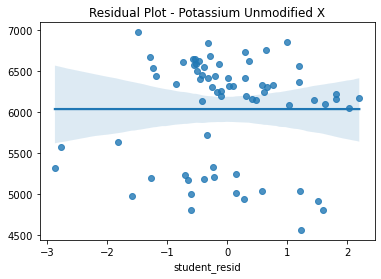

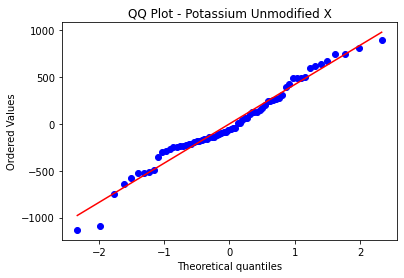

RMSE of Linear Regression of Potassium using REIP1 and Ctr2 predictors: 448.4109045125176


In [57]:
#Potassium Linear Regression
X = sample_group_level_df[["REIP1","Ctr2"]]
y = sample_group_level_df[['Potassium']]

#Split data 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Potassium Linear Regression - Unmodified X
X_train = sm.add_constant(X_train)
LR_Potassium = sm.OLS(y_train,X_train).fit()
print(LR_Potassium.summary())

#residual plot
r_student = LR_Potassium.outlier_test()["student_resid"]
sns.regplot(x=r_student,y=LR_Potassium.fittedvalues)
plt.title("Residual Plot - Potassium Unmodified X")
plt.show()
plt.close('all')

#qq plot
fig, ax = plt.subplots()
_, (__, ___, r) = stats.probplot(LR_Potassium.resid, plot=ax, fit=True)
plt.title("QQ Plot - Potassium Unmodified X")
plt.show()
plt.close('all')

# now generate predictions
X_test = sm.add_constant(X_test)
ypred = LR_Potassium.predict(X_test)

# calc rmse
rmse_LR_Potassium = rmse(y_test['Potassium'], ypred)
print("RMSE of Linear Regression of Potassium using REIP1 and Ctr2 predictors: " + str(rmse_LR_Potassium))

Potassium has best RMSE on Linear Regression using REIP1 and Ctr2 predictors: 448.41.

I am not happy with this result and will have to think a bit about how to improve it.

### health_state

#### Decision Tree

Trying to get a simple explanation on where there is a differentiator in health_state class.

In [58]:
#Decision Tree
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['diseased']]

#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

DT_Model = DecisionTreeClassifier().fit(X_train, y_train)

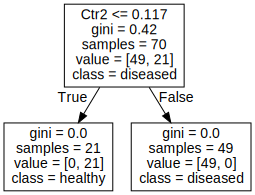

In [59]:
dot_data = tree.export_graphviz(DT_Model, out_file=None,
                               feature_names=sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]].columns,
                               class_names=sample_group_level_df["health_state"].cat.categories)
graph = graphviz.Source(dot_data) 
graph

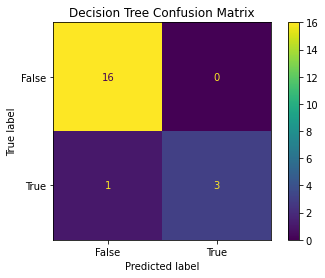

AUROC = 0.875


In [60]:
#Validation - predict function, AUROC, Confusion matrix
ypred = DT_Model.predict(X_val)

ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_val['diseased'], ypred.round()), display_labels = [False, True]).plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

print("AUROC = " + str(roc_auc_score(y_val['diseased'], ypred)))

I tried some optimization and didn't get a different result. Didn't try alot of optimization because XGBoost will do this better.

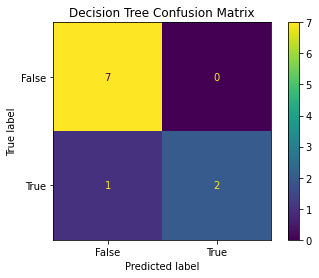

AUROC = 0.8333333333333333


In [61]:
#Test - predict function, AUROC, Confusion matrix
ypred = DT_Model.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test['diseased'], ypred.round()), display_labels = [False, True]).plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

print("AUROC = " + str(roc_auc_score(y_test['diseased'], ypred)))

#### Linear Discriminant Analysis (LDA) -- Best model (Tie)

Since the data separated by health_state is not significantly different from a normal distribution we can use LDA.

In [62]:
#LDA
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df['diseased']

#Split data 70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

LDA_Model = LinearDiscriminantAnalysis().fit(X_train, y_train)

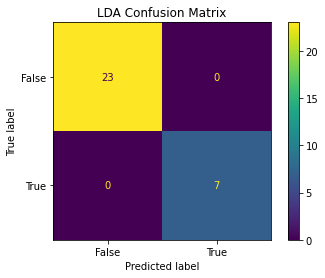

AUROC = 1.0


In [63]:
#Test - predict function, AUROC, Confusion matrix
ypred = LDA_Model.predict(X_test)

#LDA plot example: https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, ypred.round()), display_labels = [False, True]).plot()
plt.title("LDA Confusion Matrix")
plt.show()

print("AUROC = " + str(roc_auc_score(y_test, ypred)))

On average LDA performs worse than XGBoost but is much more understandable. 

For more information about LDA, read this paragraph. It puts a normal distirbution on each of the classes and predicts the likelihood of a predicted point on each class and returns the most likely. Read link for more information: https://yangxiaozhou.github.io/data/2019/10/02/linear-discriminant-analysis.html

#### XGBoost -- Best model (Tie)

In [64]:
#XGBoost
X = sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]]
y = sample_group_level_df[['diseased']]

#Split data Train 70, Validation 20, Test 10
train_ratio = 0.7
validation_ratio = 0.20
test_ratio = 0.10

# train is 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_ratio, 2), random_state=42)

# validation is 20%
# test is 10%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

#Fix index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Create xgb matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [65]:
# set training to logistic regression using probabilities
# Testing other hyperparameters through intuition
# quick guide on hyperparameter tuning https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
# documentation: https://xgboost.readthedocs.io/en/latest/parameter.html
# I didn't run on GPU acceleration because code ran fast and potential complexities surrounding gpu installation, if code is running slow, look up implementation for xgboost gpu acceleration.
# with a larger amount of data points either increase the learning rate or let training take more time.
params = {"objective": "binary:logistic",
          "eval_metric" : ["logloss"],
          'max_depth': 3,
          'learning_rate': 0.01,
          'colsample_bytree': 0.5,
          'subsample': 0.7,
          'alpha': 0,
          'lambda': 1,
          'gamma': 0}

evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

n = 50000

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   early_stopping_rounds=5
)

[0]	validation-logloss:0.68524	train-logloss:0.68447
[50]	validation-logloss:0.44138	train-logloss:0.42567
[100]	validation-logloss:0.31233	train-logloss:0.28902
[150]	validation-logloss:0.22951	train-logloss:0.19793
[200]	validation-logloss:0.18126	train-logloss:0.14546
[250]	validation-logloss:0.14307	train-logloss:0.10869
[300]	validation-logloss:0.11977	train-logloss:0.08435
[350]	validation-logloss:0.10217	train-logloss:0.06782
[400]	validation-logloss:0.08978	train-logloss:0.05549
[450]	validation-logloss:0.08052	train-logloss:0.04770
[500]	validation-logloss:0.07566	train-logloss:0.04412
[550]	validation-logloss:0.07375	train-logloss:0.04277
[600]	validation-logloss:0.07245	train-logloss:0.04141
[602]	validation-logloss:0.07245	train-logloss:0.04141


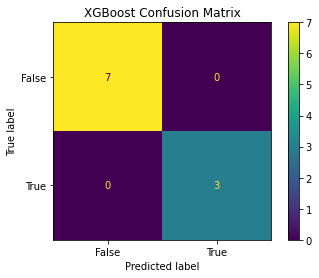

AUROC = 1.0


In [66]:
#predict function, AUROC, Confusion matrix
ypred = model.predict(dtest_reg)

ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test['diseased'], ypred.round()), display_labels = [False, True]).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

print("AUROC = " + str(roc_auc_score(y_test['diseased'], ypred)))

# User-Defined Functions

#### Cell 2 

In [2]:
def analysis_master(
    model_type,
    explanatory_variables,
    response_variable,
    train_size,
    test_size,
    val_size,
    health_csv, 
    predictors_csv
):
    """
    Master function
    train_size + test_size + val_size = 1
    train_size, test_size, val_size: Train-Val-Test splits
    Note: response_variable = health_state automatically creates a dummy variable. Plan to implement a general dummy creation function depending on time.
    """
    
    # Turn csv's into pandas dataframes
    health = pd.read_csv(health_csv)
    predictors = pd.read_csv(predictors_csv)
    
    # Merge by sample group to get one dataframe with predictors and health data
    sample_level_df = pd.merge(predictors, health, on="sample_group_id")
    
    # Take the mean of the predictors for the sample group
    ### Is averaging all sample group IDs a valid assumption? If so, why?
    sample_group_level_df = sample_level_df.groupby(["sample_group_id","health_state"]).mean().reset_index()
    
    #Changing health_state to categorical data.
    sample_group_level_df['health_state'] = sample_group_level_df['health_state'].astype('category')
    
    # Create Diseased Dummy column from health_state column
    sample_group_level_df['diseased'] = pd.get_dummies(sample_group_level_df["health_state"], dtype=int)['diseased']
    
    # Check that input variables are available
    for var in explanatory_variables:
        if var not in sample_group_level_df.columns:
            return None, f"Error: {var} not in set of predictors"
        else:
            pass
    if response_variable not in sample_group_level_df.columns:
        return None, f"Error: {response_variable} not in set of responses"
    else:
        pass
    
    X = sample_group_level_df[explanatory_variables]
    
    if response_variable == "health_state":
        y = sample_group_level_df[['diseased']]
    else:
        y = sample_group_level_df[[response_variable]]
    
    #Split data Train, Validation, Test
    # Create train df
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=round(1 - train_size, 2), random_state=42)

    # validation and test df
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size/(test_size + val_size), random_state=42) 

    #Fix index
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    # Create xgb matrices
    dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)
    dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

    # Find best algorithm
    # not enough time to implement potential errors into code.
    model, model_name = find_best_algorithm(model_type = model_type, X_train = X_train, X_val = X_val, y_train = y_train, y_val = y_val, 
                                dtrain_reg = dtrain_reg, dval_reg = dval_reg, response_variable = response_variable, sample_group_level_df = sample_group_level_df)
    #if err is not None:
    #    return None, err
    #assert type(best_model) == str
    
    # Predict using best model
    #model = eval(best_model)()
    #model.fit(X_train, y_train)
    print(f"{model_name} is best model.")
    if model_name == "Linear_Regression":
        X_test = sm.add_constant(X_test)
        
    if model_name == "XGBoost":
        y_pred = model.predict(dtest_reg)
    else:
        y_pred = model.predict(X_test)
    
    # Output material
    err = show_output_material(model_type = model_type, model_name = model_name, response_variable = response_variable, 
                               model = model, X_test = X_test, y_test = y_test, dtest_reg = dtest_reg, y_pred = y_pred, 
                               explanatory_variables = explanatory_variables, sample_group_level_df = sample_group_level_df)
    
    return model, err

#### Cell 3

In [3]:
def find_best_algorithm(
    model_type, 
    X_train,
    X_val,
    y_train,
    y_val,
    dtrain_reg,
    dval_reg,
    response_variable,
    sample_group_level_df
):
    """
    I have implemented this function to test different models and pick the best model.
    
    This code doesn't optimize for hyperparameters so those models must be done manually. 
    I can optimize for hyperparameters but it might miss the best combination and/or take a long time with grid search.
    """
    def find_best_metric(best_metric, metric, best_model, model, best_model_name, model_name, greater_than=True):
        if greater_than:
            if metric > best_metric:
                return metric, model, model_name
            else:
                return best_metric, best_model, best_model_name
        else:
            if metric < best_metric:
                return metric, model, model_name
            else:
                return best_metric, best_model, best_model_name
    
    if model_type == "regression":
        #linear regression - using to get baseline RMSE and set baseline parameters.
        X_train_LR = sm.add_constant(X_train)
        LR_model = sm.OLS(y_train,X_train_LR).fit()
        X_val_LR = sm.add_constant(X_val)
        ypred = LR_model.predict(X_val_LR)
        rmse_LR = rmse(y_val[response_variable], ypred)
        best_metric = rmse_LR
        best_model = LR_model
        best_model_name = "Linear_Regression"
        
        #XGBoost
        print(f"Please make sure XGBoost Hyperparameters are update to date for {response_variable}.")
        if response_variable == "Nitrogen":
            # set training to squarederror regression
            # Testing other hyperparameters through intuition
            # quick guide on hyperparameter tuning https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
            # documentation: https://xgboost.readthedocs.io/en/latest/parameter.html
            # I didn't run on GPU acceleration because code ran fast and potential complexities surrounding gpu installation, if code is running slow, look up implementation for xgboost gpu acceleration.
            # with a larger amount of data points either increase the learning rate or let training take more time.
            # hyperparameters = [max_depth, learning_rate, colsample_bytree, subsample, alpha, lambda, gamma] Note: these are just the ones I used.
            params = {"objective": "reg:squarederror",
                      'max_depth': 7,
                      'learning_rate':0.01,
                      'colsample_bytree': 0.5,
                      'subsample':0.6,
                      'alpha':0,
                      'lambda':1,
                      'gamma':3}

            evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

            n = 480
            
            #Training
            model = xgb.train(
               params=params,
               dtrain=dtrain_reg,
               num_boost_round=n,
               evals=evals,
               verbose_eval=False,
               early_stopping_rounds=5
            )
            
            #Predicting on Validation
            ypred = model.predict(dval_reg)
            rmse_XGB = rmse(y_val[response_variable], ypred)
            
            #Determining Best Model
            best_metric, best_model, best_model_name = find_best_metric(best_metric, rmse_XGB, best_model, model, best_model_name, "XGBoost", greater_than=False)
        
        elif response_variable == "Phosphorous":
            # hyperparameters = [max_depth, learning_rate, colsample_bytree, subsample, alpha, lambda, gamma] Note: these are just the ones I used.
            params = {"objective": "reg:squarederror",
                      'max_depth': 8,
                      'learning_rate':0.01,
                      'colsample_bytree': 0.6,
                      'subsample':0.5,
                      'alpha':0,
                      'lambda':1,
                      'gamma':1}

            evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

            n = 405

            model = xgb.train(
               params=params,
               dtrain=dtrain_reg,
               num_boost_round=n,
               evals=evals,
               verbose_eval=False,
               early_stopping_rounds=5
            )
            
            #Predicting on Validation
            ypred = model.predict(dval_reg)
            rmse_XGB = rmse(y_val[response_variable], ypred)
            
            #Determining Best Model
            best_metric, best_model, best_model_name = find_best_metric(best_metric, rmse_XGB, best_model, model, best_model_name, "XGBoost", greater_than=False)
        
        elif response_variable == "Potassium":
            # hyperparameters = [max_depth, learning_rate, colsample_bytree, subsample, alpha, lambda, gamma] Note: these are just the ones I used.
            params = {"objective": "reg:squarederror",
                      'max_depth': 8,
                      'learning_rate': 0.01,
                      'colsample_bytree': 0.5,
                      'subsample': 0.6,
                      'alpha': 0.5,
                      'lambda': 1,
                      'gamma': 1}

            evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

            n = 630

            model = xgb.train(
               params=params,
               dtrain=dtrain_reg,
               num_boost_round=n,
               evals=evals,
               verbose_eval=False,
               early_stopping_rounds=5
            )
            
            #Predicting on Validation
            ypred = model.predict(dval_reg)
            rmse_XGB = rmse(y_val[response_variable], ypred)
            
            #Determining Best Model
            best_metric, best_model, best_model_name = find_best_metric(best_metric, rmse_XGB, best_model, model, best_model_name, "XGBoost", greater_than=False)

        #Elastic Net Regression
        #Pick hyperparameter based on previous testing.
        if response_variable == "Nitrogen" or response_variable == "Phosphorous":
            l1_ratio=0
        elif response_variable == "Potassium":
            l1_ratio=1

        #Training
        #Hyperparameters: [l1_ratio, alpha]
        #if l1_ratio != 0 or 1 then I would change alpha but personally I like alpha <= 1 and am happy with alpha = 1.
        #Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
        LR_EN = ElasticNet(random_state=42, l1_ratio=l1_ratio)
        LR_EN.fit(X_train, y_train)

        #Predicting on Validation
        ypred = LR_EN.predict(X_val)
        rmse_EN = rmse(y_val[response_variable], ypred)

        #Determining Best Model
        best_metric, best_model, best_model_name = find_best_metric(best_metric, rmse_EN, best_model, rmse_EN, best_model_name, "Elastic_Net_Regression", greater_than=False)
    
    elif model_type == "classification":
        ###Decision Tree Classifier
        #Trying to get a simple explanation on where there is a differentiator in health_state class.
        #Training
        DT_Model = DecisionTreeClassifier().fit(X_train, y_train)
        
        #Validation - predict function, AUROC, Confusion matrix
        ypred = DT_Model.predict(X_val)

        #Assigning best values
        best_metric = roc_auc_score(y_val['diseased'], ypred)
        best_model = DT_Model
        best_model_name = "Decision_Tree_Classifier"
        
        ###XGBoost
        # set training to logistic regression using probabilities
        # hyperparameters = [max_depth, learning_rate, colsample_bytree, subsample, alpha, lambda, gamma] Note: these are just the ones I used.
        params = {"objective": "binary:logistic",
                  "eval_metric" : ["logloss"],
                  'max_depth': 3,
                  'learning_rate': 0.01,
                  'colsample_bytree': 0.5,
                  'subsample': 0.7,
                  'alpha': 0,
                  'lambda': 1,
                  'gamma': 0}

        evals = [(dval_reg, "validation"), (dtrain_reg, "train")]

        n = 50000

        model = xgb.train(
           params=params,
           dtrain=dtrain_reg,
           num_boost_round=n,
           evals=evals,
           verbose_eval=False,
           early_stopping_rounds=5
        )
        
        #predict function
        ypred = model.predict(dval_reg)
        AUC_Score = roc_auc_score(y_val['diseased'], ypred.round())
        
        #Determining Best Model
        best_metric, best_model, best_model_name = find_best_metric(best_metric, AUC_Score, best_model, model, best_model_name, "XGBoost")
        
        ###Linear Discriminant Analysis (LDA)
        #Since the data separated by health_state is not significantly different from a normal distribution we can use LDA.
        #LDA puts a normal distirbution on each of the classes and predicts the likelihood of a predicted point on each class and returns the most likely. 
        #Read link for more information: https://yangxiaozhou.github.io/data/2019/10/02/linear-discriminant-analysis.html
        LDA_Model = LinearDiscriminantAnalysis().fit(X_train, y_train["diseased"])
        
        #Validation - predict function and AUROC
        ypred = LDA_Model.predict(X_val)
        AUC_Score = roc_auc_score(y_val['diseased'], ypred.round())
        
        #Determining Best Model
        best_metric, best_model, best_model_name = find_best_metric(best_metric, AUC_Score, best_model, model, best_model_name, "LDA")
        
    return best_model, best_model_name

#### Cell 4

In [4]:
def show_output_material(
    model_type,
    model_name,
    response_variable,
    model,
    X_test,
    y_test,
    dtest_reg,
    y_pred,
    explanatory_variables,
    sample_group_level_df
):
    """
    Output information/plots to display model information and results
    """
    if model_type == "regression":
        if model_name == "Linear_Regression":
            #Model Summary statistics
            print(model.summary())
            
            #residual plot
            r_student = model.outlier_test()["student_resid"]
            sns.regplot(x=r_student,y=model.fittedvalues)
            plt.title(f"Residual Plot - {response_variable}")
            plt.show()
            plt.close('all')

            #qq plot
            fig, ax = plt.subplots()
            _, (__, ___, r) = stats.probplot(model.resid, plot=ax, fit=True)
            plt.title(f"QQ Plot - {response_variable}")
            plt.show()
            plt.close('all')
            
            #Test RMSE
            rmse_LR = rmse(y_test[response_variable], y_pred)
            print(f"RMSE of Linear Regression of {response_variable}: " + str(rmse_LR))
            
            print("Please double check all explanatory_variables are significant. Otherwise more modeling might need to be done.")
        
        elif model_name == "XGBoost":
            #More Info: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
            #https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html
            xgb.plot_importance(model)
            plt.title("Feature Importance (Weight)")
            plt.show()
            xgb.plot_importance(model, importance_type="cover")
            plt.title('Feature Importance (Cover)')
            plt.show()
            xgb.plot_importance(model, importance_type="gain")
            plt.title('Feature Importance (Gain)')
            plt.show()
            
            rmse_XGB = rmse(y_test[response_variable], y_pred)
            print(f"RMSE of XGB of {response_variable}: " + str(rmse_XGB))
        
        elif model_name == "Elastic_Net_Regression":
            #Interpretation: The larger the coefficent the more important that attribute. 
            #Be sure to account for larger base numbers in calculation since I didn't normalize or scale the predictors since this caused a great decrease in quality of the model.
            #Some examples: REIP1, the largest predictor by mean, is ~185x larger than Rededge1, the 2nd largest predictor by mean. Rededge1 is ~22.5x larger than Ctr2, the smallest predictor by mean.
            for num in range(len(explanatory_variables)):
                print(f"{explanatory_variables[num]} Coefficient: {model.coef_[num]}")
            print(f"Intercept: {model.intercept_[0]}")
            
            rmse_EN = rmse(y_test[response_variable], y_pred)
            print(f"RMSE of Elastic Net Regression of {response_variable}: {rmse_EN}")
    
    elif model_type == "classification":
        if model_name == "Decision_Tree_Classifier":
            #Display Decision Tree
            dot_data = tree.export_graphviz(model, out_file=None,
                               feature_names=sample_group_level_df[["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"]].columns,
                               class_names=sample_group_level_df["health_state"].cat.categories)
            graph = graphviz.Source(dot_data) 
            display(graph)
            
            #AUROC, Confusion matrix
            ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test['diseased'], y_pred.round()), display_labels = [False, True]).plot()
            plt.title("Decision Tree Confusion Matrix")
            plt.show()

            print("AUROC = " + str(roc_auc_score(y_test['diseased'], y_pred.round())))
                      
        elif model_name == "XGBoost":
            #More Info: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
            #https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html
            #**Weight**: The number of times a feature is used to split the data across all trees.
            #**Cover**: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
            #**Gain**: The average training loss reduction gained when using a feature for splitting.
            xgb.plot_importance(model)
            plt.title("Feature Importance (Weight)")
            plt.show()
            xgb.plot_importance(model, importance_type="cover")
            plt.title('Feature Importance (Cover)')
            plt.show()
            xgb.plot_importance(model, importance_type="gain")
            plt.title('Feature Importance (Gain)')
            plt.show()
            
            #AUROC, Confusion matrix
            ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test['diseased'], y_pred.round()), display_labels = [False, True]).plot()
            plt.title("XGBoost Confusion Matrix")
            plt.show()

            print("AUROC = " + str(roc_auc_score(y_test['diseased'], y_pred.round())))
        
        elif model_name == "LDA":
            #For LDA plot, Review: https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py
            #LDA and XGBoost ended with same result so this is a option worth exploring. I would have done this if I had more time or XGBoost didn't give a good answer.           
            #AUROC, Confusion matrix
            ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test['diseased'], y_pred.round()), display_labels = [False, True]).plot()
            plt.title("LDA Confusion Matrix")
            plt.show()

            print("AUROC = " + str(roc_auc_score(y_test['diseased'], y_pred.round())))

# Analysis Results

How were predictors calculated compared to nitrogen, phosphorous, and potassium? Since these are all numeric values, some noise/variance can be inside the calculations. Understanding these methods can help determine if these numbers are significantly different which can account for a less accurate model.

What are the predictors referencing? Understanding this can help determine if the data and any conclusions I make in the following cells are logical, if there is a confounding factor, or if there is no logic and it is just noise. Here is an interesting example of why you can't only rely on data. https://www.tylervigen.com/spurious-correlations

In [5]:
#just taking code from Cell 2
health = pd.read_csv('health.csv')
predictors = pd.read_csv('predictors.csv')

sample_level_df = pd.merge(predictors, health, on="sample_group_id")

# Take the mean of the predictors for the sample group
# Is averaging all sample group IDs a valid assumption? If so, why?
sample_group_level_df = sample_level_df.groupby(["sample_group_id","health_state"]).mean().reset_index()

#checking some summary statistics of columns.
sample_group_level_df[['Clrededge710', 'Rededge1', 'REIP1', 'Ctr2', 'Datt1',
                       'Nitrogen', 'Phosphorous', 'Potassium', ]].describe()

,Clrededge710,Rededge1,REIP1,Ctr2,Datt1,Nitrogen,Phosphorous,Potassium
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.724165,3.827875,707.948867,0.169652,0.733539,1174.903631,273.668915,6083.322635
std,0.596341,0.496382,0.794054,0.055599,0.113379,120.867336,36.168149,756.542768
min,2.211713,2.114000,706.619200,0.071400,0.399400,832.411718,191.373348,4186.820932
25%,3.291834,3.595800,707.358100,0.115700,0.660250,1103.918860,247.579729,5507.338520
50%,3.830289,3.892700,707.748950,0.181300,0.742100,1170.975406,273.216986,6338.473772
75%,4.181490,4.164850,708.413250,0.210300,0.809000,1254.182442,298.686237,6620.072562
max,4.892604,5.199000,710.245000,0.303800,0.985500,1524.183615,390.562090,7257.599850


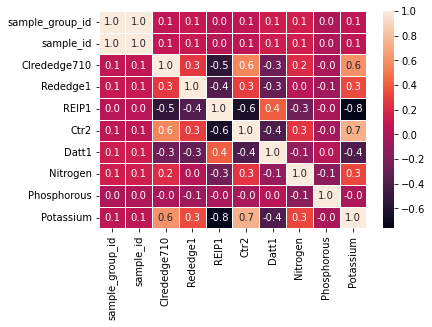

<AxesSubplot:xlabel='Rededge1', ylabel='Datt1'>

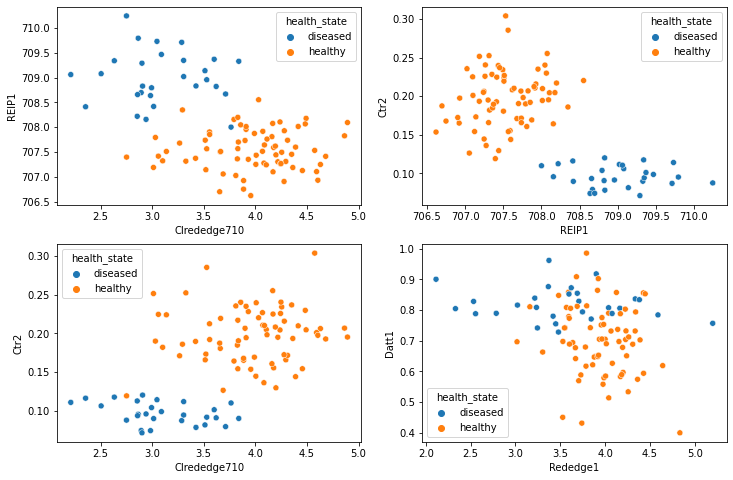

In [6]:
#correlation matrix with heatmap
corr_matrix = sample_group_level_df.corr()
sns.heatmap(corr_matrix, annot=True, linewidth=.5, fmt=".1f")
plt.show()

#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting most interesting correlations of predictors with health_state. Included Rededge1 vs Datt1 because was missing from other comparisons.
sns.scatterplot(data = sample_group_level_df, x='Clrededge710', y='REIP1', hue='health_state', ax=axes[0,0])
sns.scatterplot(data = sample_group_level_df, x='Clrededge710', y='Ctr2', hue='health_state', ax=axes[1,0])
sns.scatterplot(data = sample_group_level_df, x='REIP1', y='Ctr2', hue='health_state', ax=axes[0,1])
sns.scatterplot(data = sample_group_level_df, x='Rededge1', y='Datt1', hue='health_state', ax=axes[1,1])

#### Cell 5

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Please make sure XGBoost Hyperparameters are update to date for Nitrogen.


C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.745e+05, tolerance: 1.197e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


XGBoost is best model.


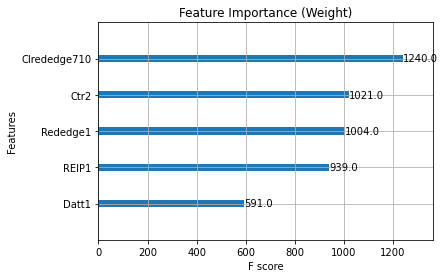

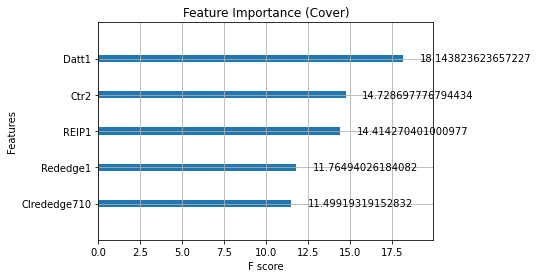

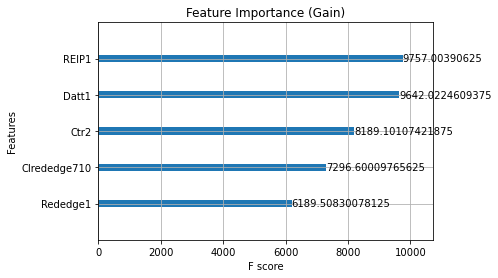

RMSE of XGB of Nitrogen: 69.05387383947073
Model: <xgboost.core.Booster object at 0x000002CFC5D45970>


In [7]:
model, err = analysis_master(
    model_type = "regression", 
    explanatory_variables = ["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"], 
    response_variable = "Nitrogen",
    train_size = 0.7,
    val_size = 0.2,
    test_size = 0.1,
    health_csv = "health.csv", 
    predictors_csv = "predictors.csv"
)
if model is not None:
    print(f"Model: {model}")
if err is not None:
    print(err)

**Weight**: The number of times a feature is used to split the data across all trees.

**Cover**: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

**Gain**: The average training loss reduction gained when using a feature for splitting.

There doesn't seem to be a strong predictor to determine Nitrogen levels. This is constant with the below scatter plots. Conclusion: All Predictors have a effect on Nitrogen.

<AxesSubplot:xlabel='Ctr2', ylabel='Nitrogen'>

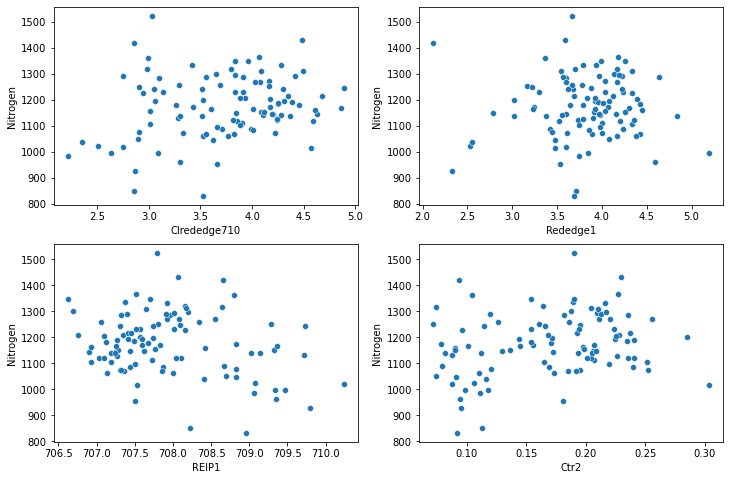

In [8]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting scatter plots of each predictor with Nitrogen
sns.scatterplot(data=sample_group_level_df, x="Clrededge710", y="Nitrogen", ax=axes[0,0])
sns.scatterplot(data=sample_group_level_df, x="Rededge1", y="Nitrogen", ax=axes[0,1])
sns.scatterplot(data=sample_group_level_df, x="REIP1", y="Nitrogen", ax=axes[1,0])
sns.scatterplot(data=sample_group_level_df, x="Ctr2", y="Nitrogen", ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='Nitrogen'>

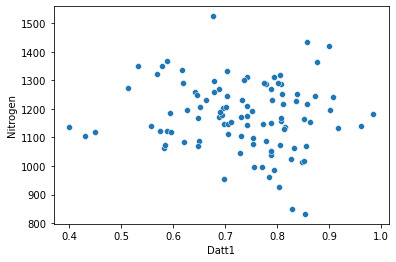

In [9]:
# separating out 5th predictor because it doesn't fit neatly
sns.scatterplot(data=sample_group_level_df, x="Datt1", y="Nitrogen")

#### Cell 6

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Please make sure XGBoost Hyperparameters are update to date for Phosphorous.


C:\Users\Tommy\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.096e+04, tolerance: 1.024e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


XGBoost is best model.


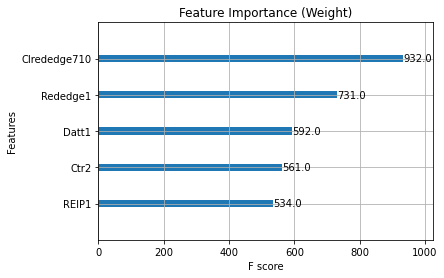

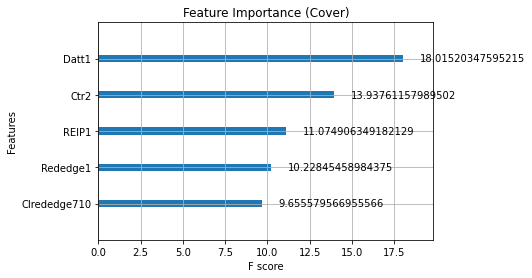

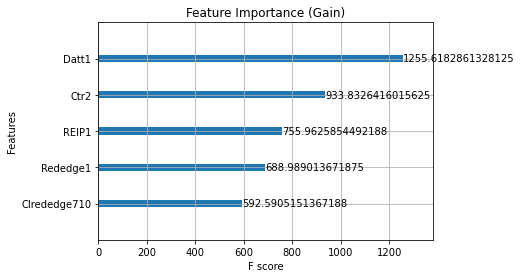

RMSE of XGB of Phosphorous: 35.616981775199605
Model: <xgboost.core.Booster object at 0x000002CFC6432CA0>


In [10]:
model, err = analysis_master(
    model_type = "regression", 
    explanatory_variables = ["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"], 
    response_variable = "Phosphorous",
    train_size = 0.7,
    val_size = 0.2,
    test_size = 0.1,
    health_csv = "health.csv", 
    predictors_csv = "predictors.csv"
)
if model is not None:
    print(f"Model: {model}")
if err is not None:
    print(err)

**Weight**: The number of times a feature is used to split the data across all trees.

**Cover**: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

**Gain**: The average training loss reduction gained when using a feature for splitting.

There doesn't seem to be a strong predictor to determine Phosphorous levels. This is constant with the below scatter plots.  Conclusion: All Predictors have a effect on Phosphorus.

<AxesSubplot:xlabel='Ctr2', ylabel='Phosphorous'>

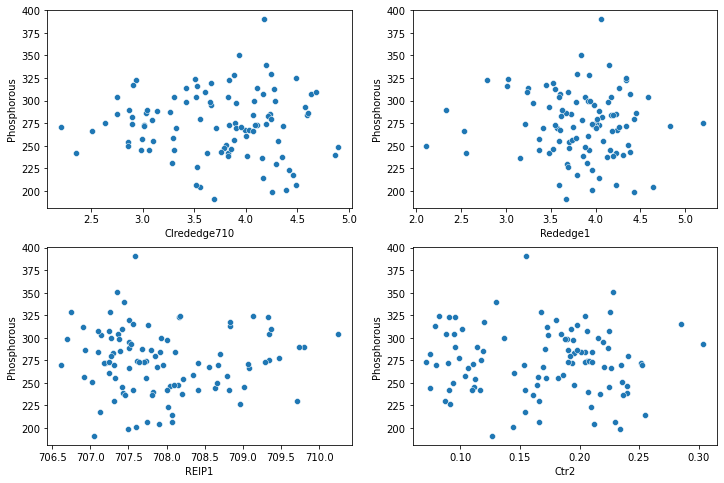

In [11]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting scatter plots of each predictor with Phosphorous
sns.scatterplot(data=sample_group_level_df, x="Clrededge710", y="Phosphorous", ax=axes[0,0])
sns.scatterplot(data=sample_group_level_df, x="Rededge1", y="Phosphorous", ax=axes[0,1])
sns.scatterplot(data=sample_group_level_df, x="REIP1", y="Phosphorous", ax=axes[1,0])
sns.scatterplot(data=sample_group_level_df, x="Ctr2", y="Phosphorous", ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='Phosphorous'>

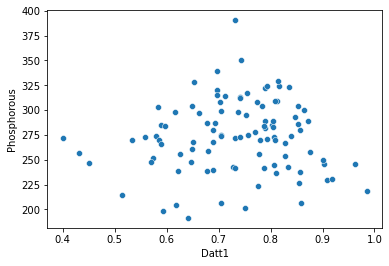

In [12]:
# separating out 5th predictor because it doesn't fit neatly
sns.scatterplot(data=sample_group_level_df, x="Datt1", y="Phosphorous")

#### Cell 7 

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Please make sure XGBoost Hyperparameters are update to date for Potassium.
XGBoost is best model.


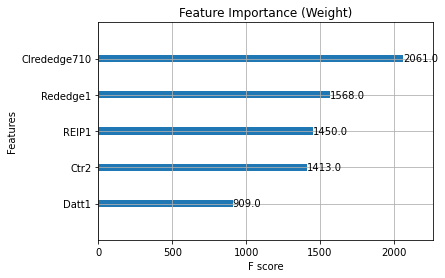

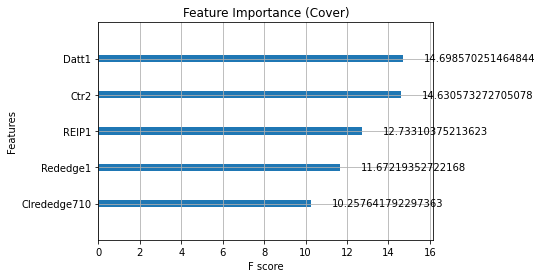

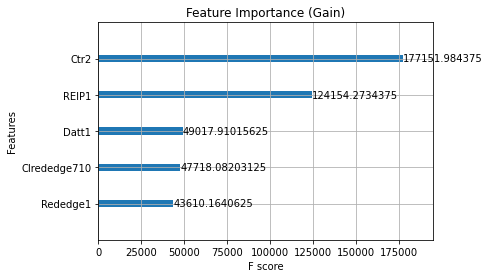

RMSE of XGB of Potassium: 468.8044765575758
Model: <xgboost.core.Booster object at 0x000002CFC643A550>


In [13]:
model, err = analysis_master(
    model_type = "regression", 
    explanatory_variables = ["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"], 
    response_variable = "Potassium",
    train_size = 0.7,
    val_size = 0.2,
    test_size = 0.1,
    health_csv = "health.csv", 
    predictors_csv = "predictors.csv"
)
if model is not None:
    print(f"Model: {model}")
if err is not None:
    print(err)

**Weight**: The number of times a feature is used to split the data across all trees.

**Cover**: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

**Gain**: The average training loss reduction gained when using a feature for splitting.

There doesn't seem to be a strong predictor to determine Potassium levels. This is constant with the below scatter plots.  Conclusion: All Predictors have a effect on Potassium.

I am not happy with the RMSE of Potassium but I optimized all the models as best as I could and all the models were around these values.

<AxesSubplot:xlabel='Ctr2', ylabel='Potassium'>

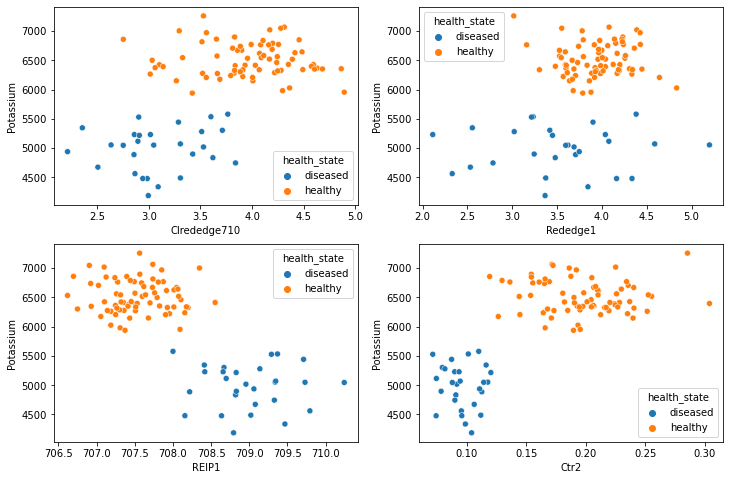

In [14]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting scatter plots of each predictor with Potassium
sns.scatterplot(data=sample_group_level_df, x="Clrededge710", y="Potassium", hue='health_state', ax=axes[0,0])
sns.scatterplot(data=sample_group_level_df, x="Rededge1", y="Potassium", hue='health_state', ax=axes[0,1])
sns.scatterplot(data=sample_group_level_df, x="REIP1", y="Potassium", hue='health_state', ax=axes[1,0])
sns.scatterplot(data=sample_group_level_df, x="Ctr2", y="Potassium", hue='health_state', ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='Potassium'>

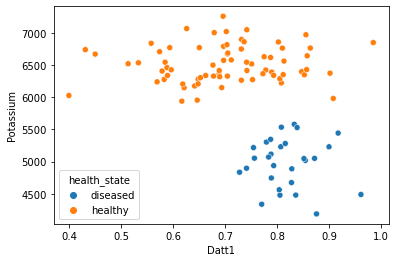

In [15]:
# separating out 5th predictor because it doesn't fit neatly
sns.scatterplot(data=sample_group_level_df, x="Datt1", y="Potassium", hue='health_state')

It is interesting how fertilizer supplies plants with plenty of Nitrogen, Phosphorous, and Potassium but Potassium is the nutrient which decreases so drastically during disease as compared to all other nutrients.

#### Cell 8

C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Tommy\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBoost is best model.


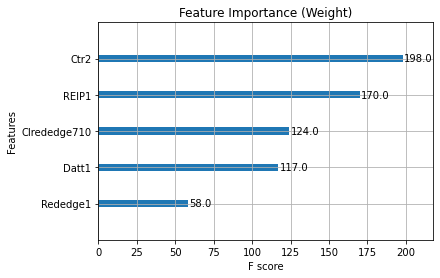

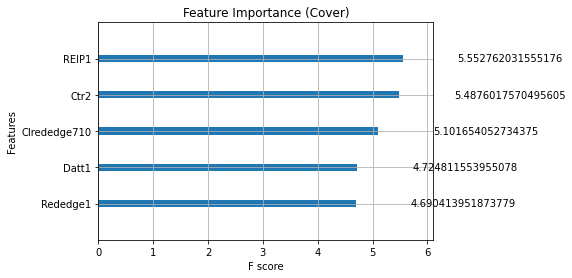

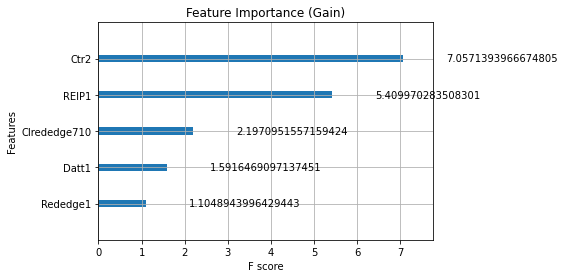

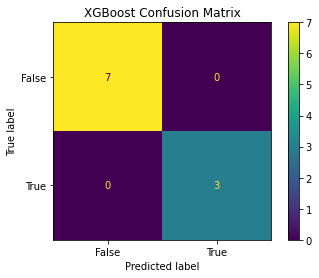

AUROC = 1.0
Model: <xgboost.core.Booster object at 0x000002CFC7897310>


In [16]:
model, err = analysis_master(
    model_type = "classification", 
    explanatory_variables = ["Clrededge710","Rededge1","REIP1","Ctr2","Datt1"], 
    response_variable = "health_state",
    train_size = 0.7,
    val_size = 0.2,
    test_size = 0.1,
    health_csv = "health.csv", 
    predictors_csv = "predictors.csv"
)
if model is not None:
    print(f"Model: {model}")
if err is not None:
    print(err)

**Weight**: The number of times a feature is used to split the data across all trees.

**Cover**: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

**Gain**: The average training loss reduction gained when using a feature for splitting.

Looking at these we can see that Ctr2 and REIP1 are the two most important features for determining the health state of plants.

<AxesSubplot:xlabel='Ctr2', ylabel='health_state'>

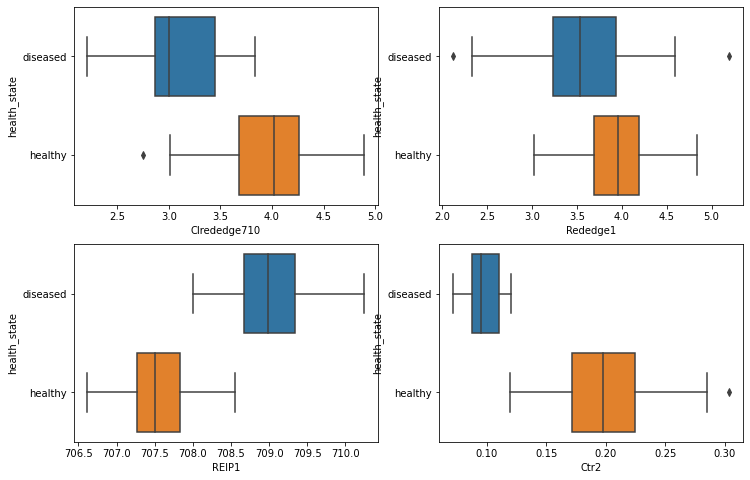

In [17]:
#creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12,8))

#charting box plots of each predictor
sns.boxplot(data=sample_group_level_df, x="Clrededge710", y="health_state", ax=axes[0,0])
sns.boxplot(data=sample_group_level_df, x="Rededge1", y="health_state", ax=axes[0,1])
sns.boxplot(data=sample_group_level_df, x="REIP1", y="health_state", ax=axes[1,0])
sns.boxplot(data=sample_group_level_df, x="Ctr2", y="health_state", ax=axes[1,1])

<AxesSubplot:xlabel='Datt1', ylabel='health_state'>

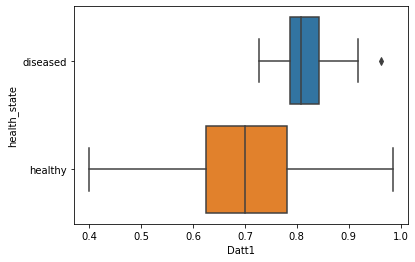

In [18]:
# separating out 5th predictor because it doesn't fit neatly
sns.boxplot(data=sample_group_level_df, x="Datt1", y="health_state")

Based on these box plots seems the model accurately determined what was shown here. Ctr2 and REIP1 are the most distinct when comparing health state of the plants.

Future Work:

LDA or PCA dimensionality reduction could help explain Nitrogen, Phosphorous, and Potassium vs predictors.

Do more work interpreting XGBoost through using models detailed in below links.
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html